# Deep Learning &mdash; Assignment 3

Third assignment for the 2021 Deep Learning course (NWI-IMC058) of the Radboud University.

_Gijs van Tulder (g.vantulder@cs.ru.nl) and Twan van Laarhoven (tvanlaarhoven@cs.ru.nl)_

_September 2021_

-----

**Names:**

**Group:**

-----

**Instructions:**
* Fill in your names and the name of your group.
* Answer the questions and complete the code where necessary.
* Keep your answers brief, one or two sentences is usually enough.
* Re-run the whole notebook before you submit your work.
* Save the notebook as a PDF and submit that in Brightspace together with the `.ipynb` notebook file.
* The easiest way to make a PDF of your notebook is via File > Print Preview and then use your browser's print option to print to PDF.

**Note:**

* The models in this assignment take a while to train. It is faster on a GPU (e.g., on Google Colab), but still doable on a CPU. Plan ahead to leave enough time to analyse your results.

## Objectives

In this assignment you will
1. Implement an LSTM module from scratch.
2. Use the built-in LSTM module from PyTorch.
3. Compare fully connected and recurrent neural networks in an experiment.
4. Experiment with data augmentation.

## Required software

If you haven't done so already, you will need to install the following additional libraries:
* `torch` and `torchvision` for PyTorch,
* `d2l`, the library that comes with [Dive into deep learning](https://d2l.ai) book.

All libraries can be installed with `pip install`.

from google.colab import drive
drive.mount('/content/drive')

In [ ]:
!pip install d2l

In [ ]:
%matplotlib inline
import csv
import glob
import re
import numpy as np
import scipy.io
import scipy.signal
import matplotlib.pyplot as plt
import torch
from d2l import torch as d2l

## 3.1 Dataset: Atrial fibrillation classification on ECG recordings

In this assignment we will work with data from the [PhysioNet Computing in Cardiology Challenge 2017](https://physionet.org/content/challenge-2017/1.0.0/) to classify atrial fibrillation in electrocardiograms (ECGs). Atrial fibrillation is an abnormal heart rhythm, which can be recognized as irregular patterns in ECG recordings.

**(A) Download the [training dataset](https://physionet.org/files/challenge-2017/1.0.0/training2017.zip) from the challenge website and extract the files.**

In [ ]:
!mkdir -p data
!wget -c -O data/training2017.zip https://physionet.org/files/challenge-2017/1.0.0/training2017.zip
!cd data/ ; unzip -qo training2017.zip

--2021-09-25 11:08:35--  https://physionet.org/files/challenge-2017/1.0.0/training2017.zip
Resolving physionet.org (physionet.org)... 18.18.42.54
Connecting to physionet.org (physionet.org)|18.18.42.54|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 99226822 (95M) [application/zip]
Saving to: ‘data/training2017.zip’

data/training2017.z 100%[===================>]  94.63M  29.4MB/s    in 3.7s    

2021-09-25 11:08:39 (25.5 MB/s) - ‘data/training2017.zip’ saved [99226822/99226822]



The dataset consists of a number of recordings and corresponding labels. We use a subset of the dataset that includes only the samples with a normal rhythm (label N or class 0) and those with atrial fibrillation (label A or class 1).

**(B) Run the code to load the data.**

In [ ]:
class ECGDataset(torch.utils.data.Dataset):
    # labels: 'N', 'A', 'O'
    def __init__(self, directory, max_length=18286, class_labels=('N', 'A', 'O')):
        super().__init__()
        self.class_labels = class_labels
        self.load_data(directory, max_length)

    def load_data(self, directory, max_length):
        label_map = {}
        with open('%s/REFERENCE.csv' % directory, 'r') as f:
            for line in csv.reader(f):
                label_map[line[0]] = line[1]

        samples = []
        lengths = []
        labels = []

        for file in sorted(glob.glob('%s/*.mat' % directory)):
            subject_id = re.match('.+(A[0-9]+)\.mat', file)[1]
            label = label_map[subject_id]
            if label not in self.class_labels:
                # skip this label
                continue
            mat_data = scipy.io.loadmat(file)
            sample = mat_data['val'][0]
            if len(sample) < 4000:
                # skip short samples
                continue
            samples.append(np.pad(sample, (0, max_length - len(sample))))
            lengths.append(len(sample))
            labels.append(self.class_labels.index(label_map[subject_id]))

        # concatenate
        samples = np.vstack(samples)
        lengths = np.stack(lengths)
        labels = np.stack(labels)
        
        # convert to PyTorch tensors
        self.samples = torch.tensor(samples, dtype=torch.float32)
        self.lengths = torch.tensor(lengths, dtype=torch.long)
        self.labels = torch.tensor(labels, dtype=torch.long)

    @property
    def class_proportions(self):
        return torch.mean((torch.arange(len(self.class_labels))[None, :] ==
                           self.labels[:, None]).to(torch.float), axis=0)
        
    def __getitem__(self, index):
        l = self.lengths[index]
        x = self.samples[index, :l]
        y = self.labels[index]
        return x, y

    def __len__(self):
        return self.samples.shape[0]


data = ECGDataset('data/training2017', class_labels=('N', 'A'))

The recordings have different lengths (between 30 to 60 seconds). There are more "normal" recordings than recordings that show atrial fibrillation.

**(C) Print some statistics of the data.**

In [ ]:
print('Number of examples: %d' % len(data))
print()
print('Minimum length: %d' % torch.min(data.lengths))
print('Median length:  %d' % torch.median(data.lengths))
print('Maximum length: %d' % torch.max(data.lengths))
print()
print('Class distribution:', data.class_proportions.numpy())

Number of examples: 5622

Minimum length: 4004
Median length:  9000
Maximum length: 18286

Class distribution: [0.87709    0.12290999]


Each example has a 1D vector that represents the ECG measurement over time.

**(D) Run the code to plot two recordings from each class.**

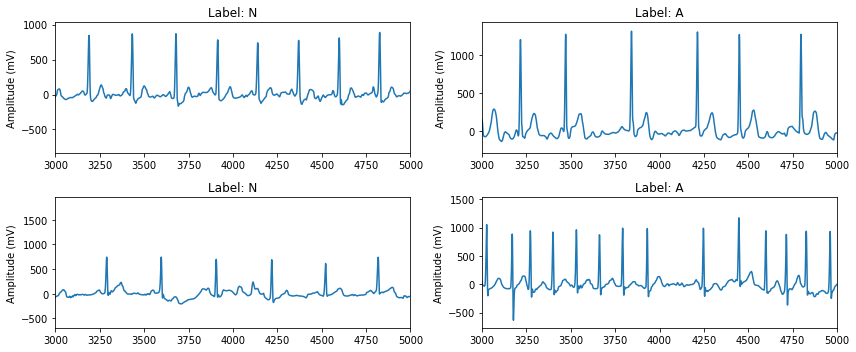

In [ ]:
plt.figure(figsize=(12, 5))
for i, idx in enumerate([0, 3, 1, 4]):
    x, y = data[idx]
    plt.subplot(2, 2, i + 1)
    plt.plot(x)
    plt.title('Label: %s' % data.class_labels[y])
    plt.xlim(3000, 5000)
    plt.ylabel('Amplitude (mV)')
plt.tight_layout()

**(E) The class distribution in this dataset is quite unbalanced. What consequences could this have?**

TODO: Your answer here.

The model will learn to predict only the one class, the one with the majority of samples, and ignore completely the other. Thus, there will be high accuracy, almost the same as the population of the most frequent class.

## 3.2 Feature extraction

To simplify our poblem a bit, we will convert the 1D ECG signals to [spectrograms](https://en.wikipedia.org/wiki/Spectrogram). A spectrogram is a summary of the frequencies in small windows of the recording. These features will make it easier to train a classification model.

**(A) Run the code to compute the spectrograms.**

In [ ]:
class ECGSpectrumDataset(ECGDataset):
    NPERSEG = 32
    NOVERLAP = 32 // 8
    
    def __init__(self, *args, **kwargs):
        super().__init__(*args, **kwargs)
        self.compute_spectrum()
    
    def compute_spectrum(self):
        f, t, Sxx = scipy.signal.spectrogram(self.samples.numpy(), scaling='spectrum',
                                             nperseg=self.NPERSEG, noverlap=self.NOVERLAP)
        # normalize the measurements for each frequency
        Sxx = Sxx - np.mean(Sxx, axis=(0, 2), keepdims=True)
        Sxx = Sxx / np.std(Sxx, axis=(0, 2), keepdims=True)
        self.samples = torch.tensor(Sxx.transpose(0, 2, 1))
        self.lengths = (self.lengths - self.NPERSEG) // (self.NPERSEG - self.NOVERLAP)

data_spectrum = ECGSpectrumDataset('data/training2017', class_labels=('N', 'A'))  

/usr/local/lib/python3.7/dist-packages/torch/_tensor.py:575: UserWarning: floor_divide is deprecated, and will be removed in a future version of pytorch. It currently rounds toward 0 (like the 'trunc' function NOT 'floor'). This results in incorrect rounding for negative values.
To keep the current behavior, use torch.div(a, b, rounding_mode='trunc'), or for actual floor division, use torch.div(a, b, rounding_mode='floor'). (Triggered internally at  /pytorch/aten/src/ATen/native/BinaryOps.cpp:467.)
  return torch.floor_divide(self, other)


**(B) Plot the spectrograms for the four samples from the previous plot.**

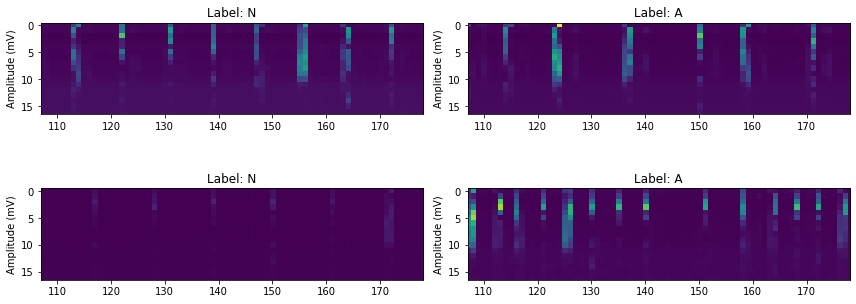

In [ ]:
plt.figure(figsize=(12, 5))
for i, idx in enumerate([0, 3, 1, 4]):
    x, y = data_spectrum[idx]
    plt.subplot(2, 2, i + 1)
    plt.imshow(x.T)
    plt.title('Label: %s' % data.class_labels[y])
    # show roughly the same segments as in the previous plot
    plt.xlim(3000 // 28, 5000 // 28)
    plt.ylabel('Amplitude (mV)')
plt.tight_layout()

The spectrogram data has 17 frequency bins for each window. We will use these as our input features. We normalized the data for each frequency to zero mean, unit variance.

**(C) Print the statistics of the spectrum dataset and check the shape of the first sample.**

In [ ]:
print('Minimum length: %d' % torch.min(data_spectrum.lengths))
print('Median length:  %d' % torch.median(data_spectrum.lengths))
print('Maximum length: %d' % torch.max(data_spectrum.lengths))
print()
print('Mean value:         %f' % torch.mean(data_spectrum.samples))
print('Standard deviation: %f' % torch.std(data_spectrum.samples))
print()
# print the shape of the first sample
x, y = data_spectrum[0]
print('Shape of first sample:', x.shape)

Minimum length: 141
Median length:  320
Maximum length: 651

Mean value:         0.000327
Standard deviation: 1.003635

Shape of first sample: torch.Size([320, 17])


## 3.3 Splitting training and validation sets

We will split our dataset in separate training and validation sets (80% &ndash; 20%).

**(A) Run the code to create a random split.**

In [ ]:
train_samples = int(0.8 * len(data))
val_samples = len(data) - train_samples
data_train, data_val = torch.utils.data.random_split(data_spectrum, (train_samples, val_samples))

print('data_train:', len(data_train))
print('data_val:  ', len(data_val))

data_train: 4497
data_val:   1125


## 3.4 Creating a balanced dataset by resampling

As you have seen, the dataset contains far more normal recordings than recordings with atrial fibrillation. We will create a balanced dataset by including multiple copies of the atrial fibrillation samples.

In this assignment we will also use a balanced validation set. This is something you may or may not want to do in practice, because it means that your validation set is no longer representative of the test data. The advantage is that the accuracy on a balanced validation set is easier to compare with the accuracy on the training set.

**(A) Run the code to create balanced training and validation sets.**

In [ ]:
def balance_dataset(dataset):
    # collect labels from the source dataset
    labels = torch.zeros((len(dataset),), dtype=torch.long)
    for i, (x, y) in enumerate(dataset):
        labels[i] = y
    indices = torch.arange(len(dataset), dtype=torch.long)

    unique_labels = np.unique(labels.numpy())
    
    # count the number of samples per class
    n = [torch.sum((labels == label).to(torch.long)).item()
         for label in unique_labels]
    
    # perhaps the dataset is already balanced?
    if len(np.unique(n)) == 1:
        return dataset
    
    print('Samples per class:', n)
    for i, label in enumerate(unique_labels):
        # we will add more samples unless every class has the same number of samples
        while n[i] < max(n):
            extra_samples = max(n) - n[i]
            print('- Repeating %d samples for class %d' % (extra_samples, label))

            # take a random subset of samples from this class
            idxs = torch.where(labels == label)[0].numpy()
            np.random.shuffle(idxs)
            idxs = torch.tensor(idxs[:extra_samples], dtype=torch.long)

            # add these indices to the list
            indices = torch.cat((indices, idxs))
            n[i] += len(idxs)
    
    return torch.utils.data.Subset(dataset, indices)

print('Balancing the training set')
data_train = balance_dataset(data_train)
print('Balancing the validation set')
data_val   = balance_dataset(data_val)

Balancing the training set
Samples per class: [3926, 571]
- Repeating 3355 samples for class 1
- Repeating 2784 samples for class 1
- Repeating 2213 samples for class 1
- Repeating 1642 samples for class 1
- Repeating 1071 samples for class 1
- Repeating 500 samples for class 1
Balancing the validation set
Samples per class: [1005, 120]
- Repeating 885 samples for class 1
- Repeating 765 samples for class 1
- Repeating 645 samples for class 1
- Repeating 525 samples for class 1
- Repeating 405 samples for class 1
- Repeating 285 samples for class 1
- Repeating 165 samples for class 1
- Repeating 45 samples for class 1


## 3.5 Splitting recordings into chunks

The recordings in our dataset all have different lengths and are generally quite long. To simplify training, we will split them into smaller chunks of 40 time steps each. This means that each recording will have multiple chunks in the dataset.

**(A) Run the code to create the pre-chunked dataset.**

In [ ]:
class ChunkedDataset(torch.utils.data.TensorDataset):
    def __init__(self, source_dataset, chunk_size=40):
        super().__init__()
        self.make_chunks(source_dataset, chunk_size)
    
    def make_chunks(self, source_dataset, chunk_size):
        all_x, all_y = [], []
        for x, y in source_dataset:
            for chunk in range(x.shape[0] // chunk_size):
                offset = chunk * chunk_size
                all_x.append(x[offset:offset + chunk_size])
                all_y.append(y)
        self.tensors = (torch.stack(all_x), torch.tensor(all_y))

chunked_data_train = ChunkedDataset(data_train)
chunked_data_val = ChunkedDataset(data_val)

# rebalance to compensate for any differences in length
chunked_data_train = balance_dataset(chunked_data_train)
chunked_data_val   = balance_dataset(chunked_data_val)

print('chunked_data_train:', len(chunked_data_train))
print('chunked_data_val:  ', len(chunked_data_val))

Samples per class: [33865, 34931]
- Repeating 1066 samples for class 0
Samples per class: [8561, 8682]
- Repeating 121 samples for class 0
chunked_data_train: 69862
chunked_data_val:   17364


## 3.6 Preparing data loaders

As in the previous assignment, we will use the PyTorch [DataLoader](https://pytorch.org/docs/stable/data.html?highlight=dataloader#torch.utils.data.DataLoader) class to divide our datasets in minibatches.

**(A) Run the code to create the data loaders. Look at the shape of the first minibatch.**

In [ ]:
chunked_loaders = {
    'train': torch.utils.data.DataLoader(chunked_data_train, shuffle=True, batch_size=128),
    'val':   torch.utils.data.DataLoader(chunked_data_val, batch_size=128),
}

# print the x and y shapes for one minibatch
for (x, y) in chunked_loaders['train']:
    print(x.shape, y.shape)
    break

torch.Size([128, 40, 17]) torch.Size([128])


## 3.7 Implementing an LSTM

Time series data such as the ECG recordings are a good target for recurrent neural networks (see [Section 8.4](http://d2l.ai/chapter_recurrent-neural-networks/rnn.html#recurrent-networks-with-hidden-states) of the D2L book).

The class below implements an RNN layer in PyTorch, using the equations discussed in [section 8.4.2](http://d2l.ai/chapter_recurrent-neural-networks/rnn.html#recurrent-networks-with-hidden-states) of the book.

**(A) Read through the code to see how the RNN works.**

In [ ]:
class RNN(torch.nn.Module):
    """RNN module.
    
    This implements an RNN module as discussed in Section 8.4 of the D2L book
    (http://d2l.ai/chapter_recurrent-neural-networks/rnn.html).

    Note that our implementation is slightly different from that in the book.
    The book also implements a linear output layer on top of the RNN, but this
    is not really part of the standard RNN or LSTM definitions.

    Our implementation only has the hidden units of the RNN, which are used as
    the output of the layer. You can then implement a separate torch.nn.Linear
    layer on top of the output of this module, if you want.
    
    Parameters:
       num_inputs:  scalar, the number of inputs to this module
       num_hiddens: scalar, the number of hidden units
    
    Input and output: see the forward function.
    """
    # see d2l.ai 8.5
    def __init__(self, num_inputs, num_hiddens):
        super().__init__()
        self.num_inputs = num_inputs
        self.num_hiddens = num_hiddens
        self.initialize_parameters()

    def initialize_parameters(self):
        """Initializes the parameters of the RNN module.
        
        This initializes the bias vector b_h and weight matrices W_xh and W_hh.
        """
        def three():
            return (torch.nn.Parameter(torch.normal(0, 0.01, size=(self.num_inputs, self.num_hiddens))),
                    torch.nn.Parameter(torch.normal(0, 0.01, size=(self.num_hiddens, self.num_hiddens))),
                    torch.nn.Parameter(torch.zeros(size=(self.num_hiddens,))))

        # parameters for the rnn
        self.W_xh, self.W_hh, self.b_h = three()

    def forward(self, inputs):
        """Computes the forward pass of the RNN module.
        
        Input:
           inputs:  a tensor of shape (samples, steps, input features)
                    giving the input for each sample at each step
        
        Output:
           outputs: a tensor of shape (samples, steps, hidden features)
                    providing the hidden values at the end of each step
           state:   a tuple (hiddens,)
                    the state of the RNN at the end of the last step,
                    with hiddens a tensor of shape (samples, hidden_features)
        """
        batch_size = inputs.shape[0]

        # initialize state
        state = (torch.zeros(size=(batch_size, self.num_hiddens),
                             dtype=inputs.dtype, device=inputs.device),)

        # run steps
        outputs = []
        for step in range(inputs.shape[1]):
            state = self.one_step(inputs[:, step], state)
            outputs.append(state[0])

        # concatenate outputs
        outputs = torch.stack(outputs, axis=1)
        return outputs, state

    def one_step(self, x, state):
        """Run a single step of the RNN module.
        
        Input:
           x:     a tensor of shape (samples, input features)
                  giving the input for each sample at the current step
           state: a tuple (hiddens,)
                  the state of the RNN at the end of the previous step,
                  with hiddens a tensor of shape (samples, hidden_features)
        """
        # extract current state
        (h,) = state

        # see http://d2l.ai/chapter_recurrent-neural-networks/rnn-scratch.html#rnn-model

        # new hidden
        h = torch.tanh(torch.mm(x, self.W_xh) + torch.mm(h, self.W_hh) + self.b_h)

        # return the state
        return (h,)

    def __repr__(self):
        return ('RNN(num_inputs=%d, num_hiddens=%d)' %
                (self.num_inputs, self.num_hiddens))


# quick sanity check
rnn = RNN(3, 5)
print(rnn)
print('Parameters:')
for name, param in rnn.named_parameters():
    print(' - %s:' % name, tuple(param.shape))

RNN(num_inputs=3, num_hiddens=5)
Parameters:
 - W_xh: (3, 5)
 - W_hh: (5, 5)
 - b_h: (5,)


The design of the LSTM module is more complex than that of the RNN, but it follows a similar pattern of looping over all steps in the input. You can use the RNN implementation as a basis for an LSTM module.

**(B) Implement the LSTM module below.**

The equations and code in [Section 9.2](http://d2l.ai/chapter_recurrent-modern/lstm.html) can provide some inspiration. Be aware that the book uses `(steps, samples, ...)` instead of `(samples, steps, ...)` as the shapes for the input and output variables, and adds an additional output layer `y`, so you probably cannot copy code directly. Use the RNN implementation above and insert the LSTM equations from the book.

In [ ]:
class LSTM(torch.nn.Module):
    def __init__(self, num_inputs, num_hiddens):
        super().__init__()
        self.num_inputs = num_inputs
        self.num_hiddens = num_hiddens
        self.initialize_parameters()

    def initialize_parameters(self):
        # TODO initialize the LSTM weights
        self.device = d2l.try_gpu()

        def normal(shape):
            return (torch.randn(size=shape, device=self.device) * 0.01)

        def three():
            return (torch.nn.Parameter(torch.normal(0, 0.01, size=(self.num_inputs, self.num_hiddens))),
                    torch.nn.Parameter(torch.normal(0, 0.01, size=(self.num_hiddens, self.num_hiddens))),
                    torch.nn.Parameter(torch.zeros(size=(self.num_hiddens,))))

        # parameters for the rnn
        # self.W_xh, self.W_hh, self.b_h = three()
        self.W_xi, self.W_hi, self.b_i = three()    # Input gate parameters
        self.W_xf, self.W_hf, self.b_f = three()    # Forget gate parameters
        self.W_xo, self.W_ho, self.b_o = three()    # Output gate parameters
        self.W_xc, self.W_hc, self.b_c = three()    # Candidate memory cell parameters
        # Output layer parameters
        self.W_hq = normal((self.num_hiddens, 128))
        self.b_q = torch.zeros(128, device=self.device)
        # Attach gradients
        self.params = [self.W_xi, self.W_hi, self.b_i, self.W_xf, self.W_hf, 
                       self.b_f, self.W_xo, self.W_ho, self.b_o, self.W_xc, 
                       self.W_hc, self.b_c, self.W_hq, self.b_q]
        for param in self.params:
            param.requires_grad_(True)

    def forward(self, inputs):
        # TODO implement the forward pass of the LSTM
        def matmul_int(I, X):
            return torch.stack([I*x for x in X])

        batch_size = inputs.shape[0]

        [W_xi, W_hi, b_i, W_xf, W_hf, b_f, W_xo, W_ho, b_o, W_xc, W_hc, b_c,
        W_hq, b_q] = self.params

        # initialize state
        # state = (torch.zeros(size=(batch_size, self.num_hiddens), dtype=inputs.dtype, device=inputs.device),)
        state = (torch.zeros((batch_size, self.num_hiddens), dtype=inputs.dtype, device=inputs.device),
                 torch.zeros((batch_size, self.num_hiddens), dtype=inputs.dtype, device=inputs.device))
    
        # run steps
        (h, c) = state
        outputs = []

        # inputs.shape = [120, 40, 17]
        for X in range(inputs.shape[1]):
            # The problem occures while adding, not while multiplying
            #   |
            #   V
            I = torch.sigmoid((inputs[:, X] @ W_xi) + (h @ W_hi) + b_i)
            F = torch.sigmoid((inputs[:, X] @ W_xf) + (h @ W_hf) + b_f)
            O = torch.sigmoid((inputs[:, X] @ W_xo) + (h @ W_ho) + b_o)
            C_tilda = torch.tanh((inputs[:, X] @ W_xc) + (h @ W_hc) + b_c)
            c = F * c + I * C_tilda
            h = O * torch.tanh(c)
            Y = (h @ W_hq) + b_q
            outputs.append(Y)

        # concatenate outputs
        outputs = torch.stack(outputs, axis=1)
        return outputs, (h, c)

    def __repr__(self):
        return ('LSTM(num_inputs=%d, num_hiddens=%d)' %
                (self.num_inputs, self.num_hiddens))


# quick sanity check
lstm = LSTM(3, 5)
print(lstm)
for name, param in lstm.named_parameters():
    print(' - %s:' % name, tuple(param.shape))

LSTM(num_inputs=3, num_hiddens=5)
 - W_xi: (3, 5)
 - W_hi: (5, 5)
 - b_i: (5,)
 - W_xf: (3, 5)
 - W_hf: (5, 5)
 - b_f: (5,)
 - W_xo: (3, 5)
 - W_ho: (5, 5)
 - b_o: (5,)
 - W_xc: (3, 5)
 - W_hc: (5, 5)
 - b_c: (5,)


## 3.8 Defining the training loop

As last week, we need to define some functions to run the train the models.

**(A) Run the code to define the functions.**

In [ ]:
def accuracy(y_hat, y):
    # Computes the mean accuracy.
    # y_hat: raw network output (before sigmoid or softmax)
    #        shape (samples, classes)
    # y:     shape (samples)
    if y_hat.shape[1] == 1:
        # binary classification
        y_hat = (y_hat[:, 0] > 0).to(y.dtype)
    else:
        # multi-class classification
        y_hat = torch.argmax(y_hat, axis=1).to(y.dtype)
    correct = (y_hat == y).to(torch.float32)
    return torch.mean(correct)

In [ ]:
def train(net, data_loaders, epochs=100, lr=0.01, device=d2l.try_gpu()):
    # Trains the model net with data from the data_loaders['train'] and data_loaders['val'].
    net = net.to(device)
    
    optimizer = torch.optim.Adam(net.parameters(), lr=lr)

    animator = d2l.Animator(xlabel='epoch',
                            legend=['train loss', 'train acc', 'validation acc'],
                            figsize=(10, 5))

    timer = {'train': d2l.Timer(), 'val': d2l.Timer()}

    for epoch in range(epochs):
        # monitor loss, accuracy, number of samples
        metrics = {'train': d2l.Accumulator(3), 'val': d2l.Accumulator(3)}

        for phase in ('train', 'val'):
            # switch network to train/eval mode
            net.train(phase == 'train')

            for i, (x, y) in enumerate(data_loaders[phase]):
                timer[phase].start()

                # move to device
                x = x.to(device)
                y = y.to(device)

                # compute prediction
                y_hat = net(x)
                if y_hat.ndim == 3:
                        if y_hat.shape[2] == 1:
                            y_hat = y_hat.reshape((y_hat.shape[0], y_hat.shape[1]))
                            y_hat = torch.transpose(y_hat, 0, 1)
                # print(y_hat.shape)
                # print(y.shape)

                if y_hat.shape[1] == 1:
                    # compute binary cross-entropy loss
                    loss = torch.nn.BCEWithLogitsLoss()(y_hat[:, 0], y.to(torch.float))
                else:
                    # compute cross-entropy loss
                    loss = torch.nn.CrossEntropyLoss()(y_hat, y)

                if phase == 'train':
                    # compute gradients and update weights
                    optimizer.zero_grad()
                    loss.backward()
                    optimizer.step()

                metrics[phase].add(loss * x.shape[0],
                                   accuracy(y_hat, y) * x.shape[0],
                                   x.shape[0])

                timer[phase].stop()

        animator.add(epoch + 1,
            (metrics['train'][0] / metrics['train'][2],
             metrics['train'][1] / metrics['train'][2],
             metrics['val'][1] / metrics['val'][2]))

    train_loss = metrics['train'][0] / metrics['train'][2]
    train_acc  = metrics['train'][1] / metrics['train'][2]
    val_acc    = metrics['val'][1] / metrics['val'][2]
    examples_per_sec = metrics['train'][2] * epochs / timer['train'].sum()
    
    print(f'train loss {train_loss:.3f}, train acc {train_acc:.3f}, '
          f'val acc {val_acc:.3f}')
    print(f'{examples_per_sec:.1f} examples/sec '
          f'on {str(device)}')

## 3.9 Constructing some networks

In the next experiments you will train different network architectures to see how they perform on the ECG dataset.

The input to all networks has the shape (samples, time steps, features) = (mb_size, 40, 17). The output should be a single feature, shape (mb_size, 1), that will be used in a binary cross-entropy loss function. (The networks should not include the final sigmoid activation function.)

Some simple baselines:
* `FullyConnectedNet`: A simple fully connected network that takes all features.
* `MeanSpectrumNet`: A fully connected network that works on the mean spectrum over all time steps.

A convolutional network:
* `ConvNet`: This network does a convolution over the time steps, using the 17 input features as channels.

Some recurrent models:
* `RNNNet`: A recurrent network with a simple RNN module.
* `LSTMNet`: A recurrent network with a more advanced LSTM module.
* `TorchLSTMNet`: The same model, but using the PyTorch implementation of the LSTM.

### FullyConnectedNet

**(A) Check the implementation of the following baseline architecture:**

* Linear layer: network inputs to 512 units followed by a ReLU.
* Linear layer: 512 to 256 units followed by a ReLU.
* Linear layer: 256 to the network output.

In [ ]:
class FullyConnectedNet(torch.nn.Module):
    def __init__(self, inputs, outputs=1):
        super().__init__()

        # by defining these layers here, they are included in the
        # parameters() list of this module, so they can be trained
        self.linear = torch.nn.Sequential(
            torch.nn.Flatten(),
            torch.nn.Linear(inputs, 512),
            torch.nn.ReLU(),
            torch.nn.Linear(512, 256),
            torch.nn.ReLU(),
            torch.nn.Linear(256, outputs)
        )
        
    def forward(self, x):
        # x shape: (samples, steps, inputs)
        return self.linear(x)

net = FullyConnectedNet(40 * 17)
print(net)

FullyConnectedNet(
  (linear): Sequential(
    (0): Flatten(start_dim=1, end_dim=-1)
    (1): Linear(in_features=680, out_features=512, bias=True)
    (2): ReLU()
    (3): Linear(in_features=512, out_features=256, bias=True)
    (4): ReLU()
    (5): Linear(in_features=256, out_features=1, bias=True)
  )
)


### MeanSpectrumNet

**(B) Check the implementation of the following baseline architecture:**

* Compute the mean spectrum (mean over the steps dimension).
* Linear layer: network inputs to 128 units followed by a ReLU.
* Linear layer: 128 to 64 units followed by a ReLU.
* Linear layer: 64 to the network output.

In [ ]:
class MeanSpectrumNet(torch.nn.Module):
    def __init__(self, inputs=17, outputs=1):
        super().__init__()

        self.net = torch.nn.Sequential(
            torch.nn.Linear(inputs, 128),
            torch.nn.ReLU(),
            torch.nn.Linear(128, 64),
            torch.nn.ReLU(),
            torch.nn.Linear(64, outputs),
        )
        
    def forward(self, x):
        # x shape: (samples, steps, inputs)
        # compute the mean over all steps
        x = torch.mean(x, axis=1)
        return self.net(x)

net = MeanSpectrumNet()
print(net)

MeanSpectrumNet(
  (net): Sequential(
    (0): Linear(in_features=17, out_features=128, bias=True)
    (1): ReLU()
    (2): Linear(in_features=128, out_features=64, bias=True)
    (3): ReLU()
    (4): Linear(in_features=64, out_features=1, bias=True)
  )
)


### ConvNet

**(C) Complete the implementation of the following architecture:**

Convolution over the steps, using frequencies as channels:
* 1D-convolution: network inputs to 32 channels, kernel size 3, ReLU.
* Average pooling: 2.
* 1D-convolution: 32 to 64 channels, kernel size 3, ReLU.
* Average pooling: 2.
* 1D-convolution: 64 to 128 channels, kernel size 3, ReLU.
* `AdaptiveAvgPool1d(1)`: Compute the mean for each channel over all steps.
* Flatten.
* Linear layer: 128 to the network output.

In [ ]:
class ConvNet(torch.nn.Module):
    def __init__(self, inputs=1, outputs=1):
        super().__init__()

        self.net = torch.nn.Sequential(
            # TODO add the convolutional and pooling layers
            torch.nn.Conv1d(inputs, 32, kernel_size=3),
            torch.nn.ReLU(),
            torch.nn.AvgPool1d(2),
            torch.nn.Conv1d(32, 64, kernel_size=3),
            torch.nn.ReLU(),
            torch.nn.AvgPool1d(2),
            torch.nn.Conv1d(64, 128, kernel_size=3),
            torch.nn.ReLU(),

            torch.nn.AdaptiveAvgPool1d(1),
            torch.nn.Flatten(),
            torch.nn.Linear(128, outputs),
        )
        
    def forward(self, x):
        # x shape: (samples, steps, inputs)
        # swap the steps and inputs dimensions, so we can convolve over
        # the steps use the frequencies as channels
        x = x.transpose(2, 1)
        return self.net(x)

net = ConvNet()

### RNNNet

**(D) Check the implementation of the following architecture:**

* RNN: network input to 128 hidden units.
* Use the final hidden state from the RNN.
* Linear layer: 128 to 128 units followed by a ReLU.
* Linear layer: 128 to the network output.

In [ ]:
class RNNNet(torch.nn.Module):
    def __init__(self, inputs=17, outputs=1):
        super().__init__()

        self.rnn = RNN(inputs, 128)
        self.linear = torch.nn.Sequential(
            torch.nn.Linear(128, 128),
            torch.nn.ReLU(),
            torch.nn.Linear(128, outputs)
        )
        
    def forward(self, x):
        # x shape: (samples, steps, inputs)
        out, (h, ) = self.rnn(x)
        
        # use the final RNN hidden state as input
        # for the fully connected part
        return self.linear(h)

net = RNNNet()
print(net)

RNNNet(
  (rnn): RNN(num_inputs=17, num_hiddens=128)
  (linear): Sequential(
    (0): Linear(in_features=128, out_features=128, bias=True)
    (1): ReLU()
    (2): Linear(in_features=128, out_features=1, bias=True)
  )
)


### LSTMNet

**(E) Implement the following architecture:** (see RNNNet for an example)

* LSTM: network input to 128 hidden units.
* Use the final hidden state from the LSTM.
* Linear layer: 128 to 128 units followed by a ReLU.
* Linear layer: 128 to the network output.

In [ ]:
class LSTMNet(torch.nn.Module):
    def __init__(self, inputs=17, outputs=1):
        super().__init__()

        # TODO define the LSTM layer and the linear network
        #      (see RNNNet for an example)
        self.lstm = LSTM(inputs, 128)
        self.linear = torch.nn.Sequential(
            torch.nn.Linear(128, 128),
            torch.nn.ReLU(),
            torch.nn.Linear(128, outputs)
        )
        
    def forward(self, x):
        # x shape: (samples, steps, inputs)
        # TODO call the LSTM layer and then the linear network
        #      (see RNNNet for an example)
        out, (h, c) = self.lstm(x)
        
        # use the final RNN hidden state as input
        # for the fully connected part
        return self.linear(h)


net = LSTMNet()
print(net)

LSTMNet(
  (lstm): LSTM(num_inputs=17, num_hiddens=128)
  (linear): Sequential(
    (0): Linear(in_features=128, out_features=128, bias=True)
    (1): ReLU()
    (2): Linear(in_features=128, out_features=1, bias=True)
  )
)


### TorchLSTMNet

Implementing your own modules can be fun and good learning experience, but it is not always the most efficient solution. The built-in [LSTM implementation](https://pytorch.org/docs/stable/generated/torch.nn.LSTM.html#torch.nn.LSTM) from PyTorch is much faster than our own version.

**(F) Implement a network similar to LSTMNet using the PyTorch torch.nn.LSTM module.**

In [ ]:
class TorchLSTMNet(torch.nn.Module):
    # TODO make this identical to LSTMNet, but use torch.nn.LSTM
    #      instead of the LSTM layer you implemented yourself
    def __init__(self, inputs=17, outputs=1):
        super().__init__()

        self.lstm_torch = torch.nn.LSTM(input_size=inputs, hidden_size=128, 
                                  num_layers=1, batch_first=True)
        self.linear = torch.nn.Sequential(
            torch.nn.Linear(128, 128),
            torch.nn.ReLU(),
            torch.nn.Linear(128, outputs)
        )
        # self.model = torch.nn.Sequential()

    def forward(self, x):
        # x shape: (samples, steps, inputs)
        # LSTM requires (steps, samples, inputs) if batch_first=False
        # TODO: transpose x or batch_first=True
        # samples, steps, inputs = x.shape
        # x = torch.reshape(x, (steps, samples, inputs))
        out, (h, _) = self.lstm_torch(x)
        
        return self.linear(h)

net = TorchLSTMNet()
print(net)

TorchLSTMNet(
  (lstm_torch): LSTM(17, 128, batch_first=True)
  (linear): Sequential(
    (0): Linear(in_features=128, out_features=128, bias=True)
    (1): ReLU()
    (2): Linear(in_features=128, out_features=1, bias=True)
  )
)


## 3.10 Experiments

**(A) Train the models on the chunked dataset.**

train loss 0.554, train acc 0.695, val acc 0.559
79184.2 examples/sec on cpu


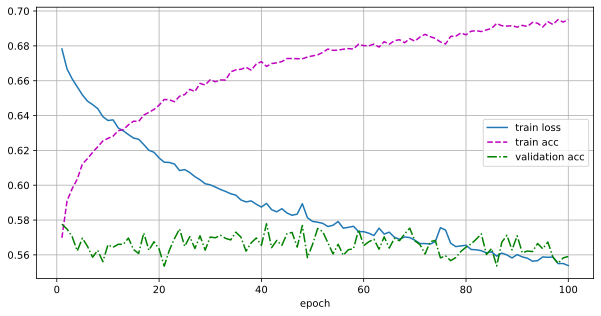

In [ ]:
train(MeanSpectrumNet(), chunked_loaders, epochs=100, lr=0.01)

train loss 0.067, train acc 0.984, val acc 0.788
10372.1 examples/sec on cpu


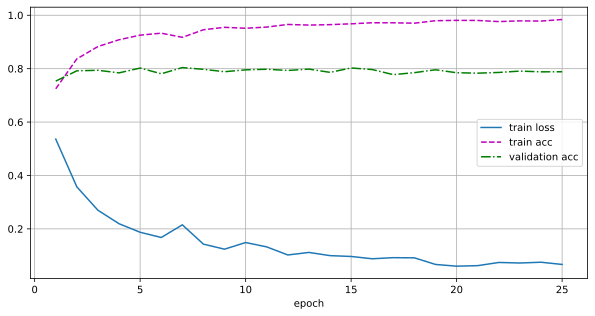

In [ ]:
train(FullyConnectedNet(40 * 17), chunked_loaders, epochs=25, lr=0.01)

train loss 0.084, train acc 0.971, val acc 0.883
7043.3 examples/sec on cpu


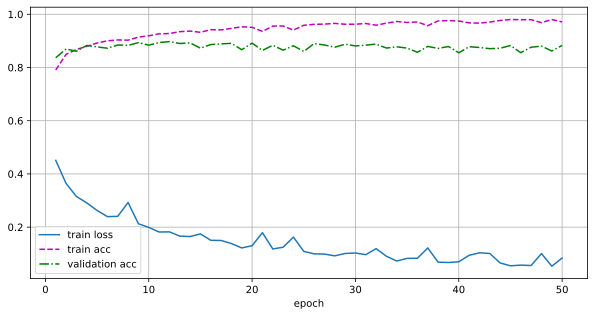

In [ ]:
train(ConvNet(17), chunked_loaders, epochs=50, lr=0.01)

train loss 0.698, train acc 0.501, val acc 0.498
2838.2 examples/sec on cpu


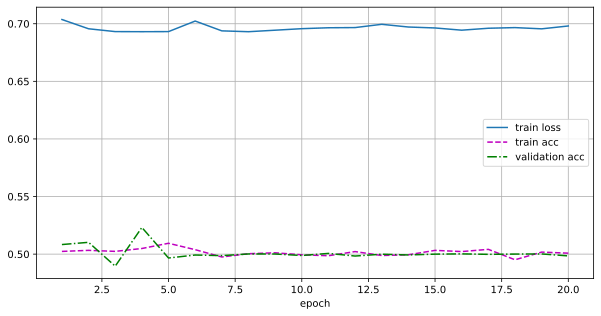

In [ ]:
train(RNNNet(17), chunked_loaders, epochs=20, lr=0.01)

train loss 0.664, train acc 0.589, val acc 0.578
2878.0 examples/sec on cuda:0


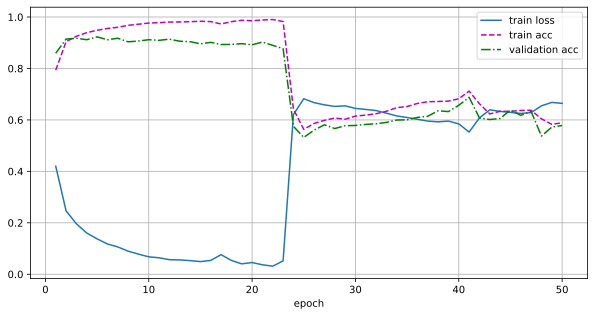

In [ ]:
train(LSTMNet(17), chunked_loaders, epochs=50, lr=0.01)

train loss 0.017, train acc 0.995, val acc 0.884
2849.9 examples/sec on cuda:0


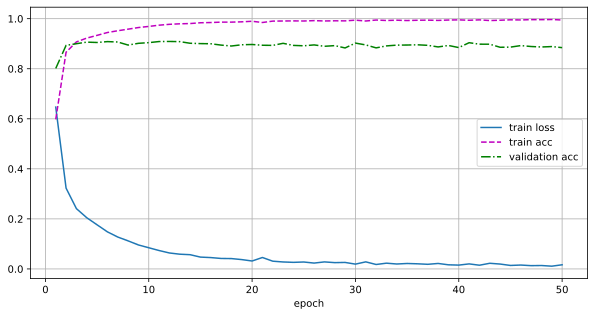

In [ ]:
train(LSTMNet(17), chunked_loaders, epochs=50, lr=0.005)

train loss 0.072, train acc 0.975, val acc 0.896
1541.2 examples/sec on cpu


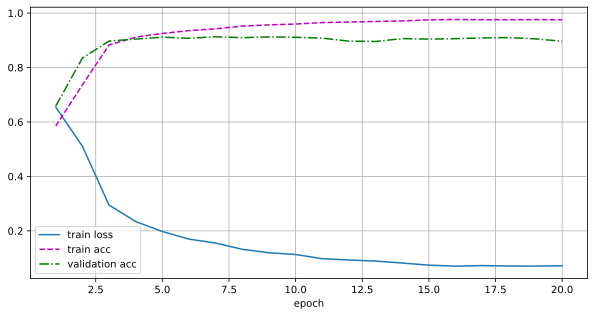

In [ ]:
train(TorchLSTMNet(17), chunked_loaders, epochs=20, lr=0.01)

## 3.11 Discussion

**(A) Briefly discuss and compare the performance of the models in your experiments. Which worked best and why?**

TODO: Your answer here.

* *MeanSpectrumNet*: in this network while the training accuracy manages to rise over epochs, the important, validation accuracy remains almost stationary to 0.55. While training accuracy is enhancing each epoch, validation accuracy does not have any improvement. It means we have an overfitting problem that the network cannot generalize what it is learning.

* *FullyConnectedNet*: in this network the loss drop quickly, the training accuracy raises to almost 1, thought the validation accuracy remains almost stationary to 0.8 and thus it performs better than the *MeanSpectrumNet*. In this model, there is also the overfitting problem.

* *ConvNet*: in this network both accuracies starts high (i.e. over 0.8) and the validation accuracy manages to raise up to 0.883, giving us better results than the simplistic *FullyConnectedNet*. However, we could not receive an appropriate validation accuracy, yet.

* *RNNNet*: this network has the poorest perfomance of all, with loss remaining high and training and validaiton accuracy being stuck around 0.5. Apparently, the network could not learn anything and it determines labels almost randomly (50 - 50).

* *(Torch)LSTMNet*: LSTM networks are performing better than others. We can interpret their high efficiency from validation accuracy.  


**(B) Why do some of those models generalize better than others?**

TODO: Your answer here.

For a model to generalise better there are some factors that contribute to it. These factors are *limiting the number of weights*, *weight sharing*, *stopping training early*, *regularization*, *weight decay*, and *adding noise to the inputs*.

CNN operates better than Fully connected and Mean Spectrum because there are much fewer parameters to train in this network. But it performs worse than LSTM because it does not consider the orientation of data. Memory cells in LSTM can help to restore the history of sequential data.

**(C) How does your LSTM implementation compare with the PyTorch implementation?**

TODO: Your answer here.

In the same value of hyper-parameters (lr = 0.01), our LSTM could not coverage. By changing the lr to 0.005, we could receive a result so close to the PyTorch result. It is converged, but it seems it suffers from a bit of overfitting.


**(D) Your RNN model probably didn't work well. Why is that model more difficult to train than the LSTM?**

TODO: Your answer here.

The RNN is worse than the LSTM cannot handle information in memory for the long period of time.

**(E) The convolutional network and the LSTM in these experiments both work on the time dimension. What are the advantages and disadvantages of each approach?**

TODO: Your answer here.

An LSTM performs more effectively than a CNN because it can accept a sequence of data (time-series data). A CNN does not record the position and orientation of an object. Also, LSTMs can read more data each sequence that is so helpful in the training process. Moreover, demanding more amount of data to learn is another disadvantage of CNNs.
On the other hand, an LSTM is a so memory-consuming model since an LSTM needs 4 layers per cell. LSTMs are more computationally expensive than CNNs because they have much more parameters to train. Reducing the number of parameters in training is the most notable improvement of CNNs.




**(F) For reasons of speed, we used a fairly small window of 40 time steps. Suppose that we would make this window much larger. How do you think this would affect each model?**

TODO: Your answer here.

All the network except the LSTM cannot handle large inputs, so the resuls would be worse. In constrast, the LSTM would perform the same or better, because it has the memory cells and can utilize the extra information.

**(G) One of the difficulties with recurrent networks is that inputs from early steps are quite far away from the final result. How would you suggest to reduce that problem?**

TODO: Your answer here.

Transfer learning is our suggestion. Since the network needs to learn initial features at the first stages, the result is not pleasant. But by fine-tuning, the model we can solve this problem. We need to use one pretrained model with acceptable performance.


## 3.12 Data augmentation

Especially if your dataset is small, data augmentation can help to improve the performance of your network.

We have an easy way to add some data augmentation to the ECG dataset. In our preprocessing, we divided each recording into small chunks of 40 time steps, which we then reused in every epoch. We can add more variation to the training set by creating chunks at random positions.

The [DataLoader](https://pytorch.org/docs/stable/data.html) class in PyTorch has a `collate_fn` parameter to which we can pass a function. This function is called for each minibatch in each epoch. We will use this to extract a random chunk from each sample.

The function `random_chunk_collate_fn` takes a minibatch of samples, chooses a random offset for each sample, extracts a small chunk at that position, and then concatenates and returns the result.

In [ ]:
def random_chunk_collate_fn(samples, window_size):
    # Take a list of tensors of (steps_i, features),
    # extract a random window of length window_size from each tensor,
    # concatenate to a tensor of shape (samples, window_size, features).
    x_batch = torch.empty((len(samples), window_size) + samples[0][0].shape[1:],
                          device=samples[0][0].device, dtype=samples[0][0].dtype)
    y_batch = torch.empty((len(samples),),
                          device=samples[0][1].device, dtype=samples[0][1].dtype)
    for i, (x, y) in enumerate(samples):
        # extract a random window
        offset = torch.randint(x.shape[0] - window_size, (1,))
        x_batch[i, :] = x[offset:offset + window_size]
        y_batch[i] = y
    return x_batch, y_batch

We construct a new DataLoader for our training set:

In [ ]:
# test to see the x and y shapes for one sample
random_chunk_loaders = {
    'train': torch.utils.data.DataLoader(data_train, shuffle=True, batch_size=128,
                                         collate_fn=lambda s: random_chunk_collate_fn(s, window_size=40)),
    'val':   chunked_loaders['val']
}
for (x, y) in random_chunk_loaders['train']:
    print(x.shape, y.shape)
    break

torch.Size([128, 40, 17]) torch.Size([128])


Observe that the pre-chunked dataset was much larger than the new dataset with on-the-fly chunking. You might want to increase the number of training epochs a bit to make sure that the network sees a similar number of examples.

In [ ]:
print('Minibatches in chunked_loader[\'train\']:      ', len(chunked_loaders['train']))
print('Minibatches in random_chunk_loaders[\'train\']:', len(random_chunk_loaders['train']))

Minibatches in chunked_loader['train']:       551
Minibatches in random_chunk_loaders['train']: 62


Let's see how this data augmentation method affects the performance of your networks.

**(A) Train the MeanSpectrumNet, FullyConnectedNet, ConvNet and TorchLSTMNet from the previous experiments on data from the `random_chunk_loaders`.**

train loss 0.644, train acc 0.620, val acc 0.574
53696.8 examples/sec on cpu


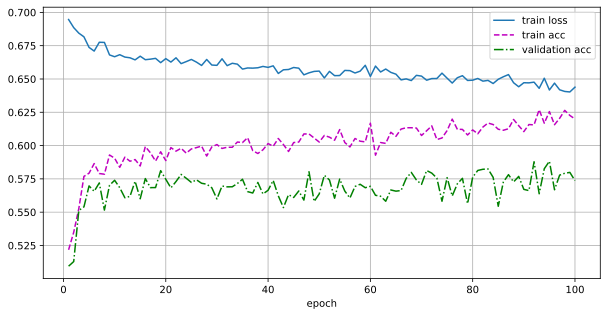

In [ ]:
train(MeanSpectrumNet(), random_chunk_loaders, epochs=100, lr=0.01)

train loss 0.370, train acc 0.837, val acc 0.854
9515.9 examples/sec on cpu


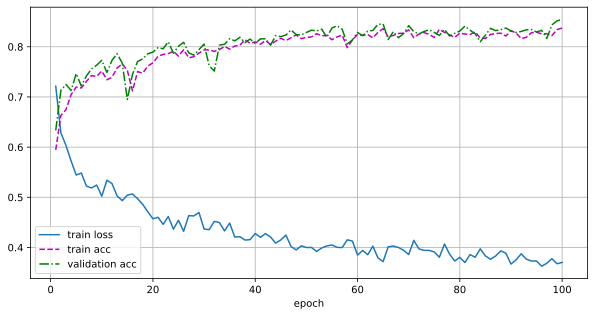

In [ ]:
train(FullyConnectedNet(40 * 17), random_chunk_loaders, epochs=100, lr=0.01)

train loss 0.289, train acc 0.876, val acc 0.878
6943.9 examples/sec on cpu


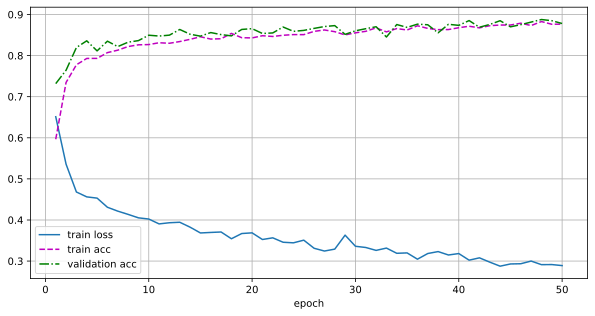

In [ ]:
train(ConvNet(17), random_chunk_loaders, epochs=50, lr=0.01)

train loss 0.092, train acc 0.966, val acc 0.931
1543.2 examples/sec on cpu


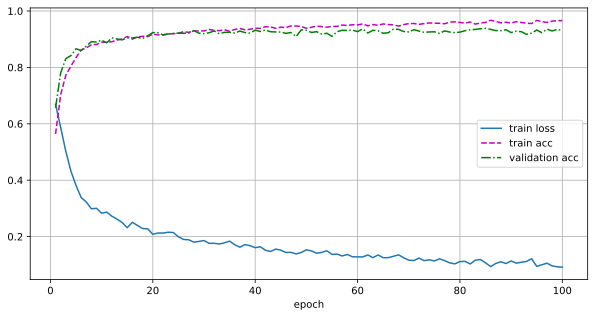

In [ ]:
train(TorchLSTMNet(17), random_chunk_loaders, epochs=100, lr=0.01)

## 3.13 Discussion

**(A) How does the data augmentation influence the results? Can you explain this?**

TODO: Your answer here.



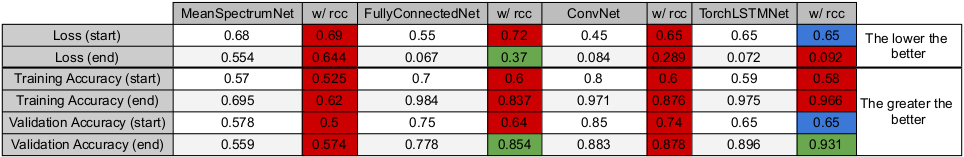

As we can see in the picture above, the results becomes worse in almost every case. Though, the import results which is the validation accuracy in the LSTM, the results is the best that we have achieved. And so, the random chunk colation has work for the LSTM.

**(B) Why does the data augmentation affect some models more than others?**

TODO: Your answer here.

Some models are more sensitive in noise, while others can learn to generalise through this.

**(C) Should we also do data augmentation on the validation set? Why, or why not?**

TODO: Your answer here.

By doing data augmentation in the validation set we would just get worse  validation accuracy. because the model would try to predict a value of random input and not of a real recording.

**(D) Data augmentation is often a good way to add some domain knowledge to your model. Based on your knowledge of ECGs, why is (or isn't) our augmentation method a good idea?**

TODO: Your answer here.

Given the fact that we processing heart signals that are sensitive waves, in which every anomally can refer to another disease, it might not be the best choice to use this type of data augmentation for this specific application.

**(E) Give an example of another suitable augmentation method and explain why it would work for this data.**

TODO: Your answer here.

Given that the two classes are imbalanced we could to Random Oversampling of the class with the fewer recordings.

**(F) Give an example of an augmentation method that might be suitable for other data but would probably not work here. Explain why.**

TODO: Your answer here.

Most literature about data augmentation is for images, where the augmentation techniques have to do with rotating, crop or fliping an image. These techniques could work great in model that work with images, but not in this one.

## The end

Well done! Please double check the instructions at the top before you submit your results.